In [2]:
from sympy import Matrix, symbols, transpose, zeros, simplify
import numpy as np
import sympy as sp
import itertools
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit
from scipy.stats import linregress

In [3]:
r_m_val = 0.1
k_val = 2 * np.pi * 6
m_val = 2 * np.pi * 3
m_u_val = 2 * np.pi * 7
dt_val = 0.001
total_time_val = 200
k_e_square_val = k_val**2 + m_val**2
k_plus_square_val = k_val**2 + (m_val + m_u_val)**2



In [4]:
# dxdt = Matrix([Delta_C_dot[i, j] for i in range(4) for j in range(4)] + [Delta_U_dot])
# k_plus_square_val = k_val**2 + (m_val + m_u_val)**2

In [5]:
epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time = symbols('epsilon N_0_squared r_m k m m_u dt total_time')
k_plus_square, k_e_square = symbols('k_plus_square k_e_square')
Delta_U, U_star = symbols('Delta_U U_star')

Zero_array = Matrix.zeros(2, 2)
W_e = Matrix([[-1, k / k_e_square], [-k * N_0_squared, -1]])
W_plus = Matrix([[-1, -k / k_plus_square], [k * N_0_squared, -1]])
L_e_plus = Matrix([[(-k / (2 * k_e_square)) * (k_plus_square - m_u**2), 0], [0, k / 2]])
L_plus_e = Matrix([[(-k / (2 * k_plus_square)) * (m_u**2 - k_e_square), 0], [0, -k / 2]])

In [6]:
L = Matrix([
    [Zero_array, L_e_plus],
    [L_plus_e, Zero_array]
])

W = Matrix([
    [W_e, Zero_array],
    [Zero_array, W_plus]
])


In [7]:
C_star = Matrix(4, 4, symbols('C_star:16'))

Delta_C = Matrix(4, 4, symbols('Delta_C:16'))

x = Matrix([Delta_C[i, j] for i in range(4) for j in range(4)] + [Delta_U])

Delta_C_dot = Delta_U * (L * C_star + C_star * L.T) + W * Delta_C + U_star * (L * Delta_C + Delta_C * L.T) + Delta_C * W.T 

Delta_U_dot = 0.25 * k * (k_plus_square - k_e_square) * Delta_C[0, 2] - r_m * Delta_U #the C element

dxdt = Matrix([Delta_C_dot[i, j] for i in range(4) for j in range(4)] + [Delta_U_dot])

A = dxdt.jacobian(x)

In [8]:
A

Matrix([
[                                                -2,                                       k/k_e_square,  -U_star*k*(k_plus_square - m_u**2)/(2*k_e_square),                                                  0,                                       k/k_e_square,            0,                                                 0,                0,  -U_star*k*(k_plus_square - m_u**2)/(2*k_e_square),                                                 0,                                                 0,                                                 0,                                                  0,                0,                                                 0,                0,   -C_star2*k*(k_plus_square - m_u**2)/(2*k_e_square) - C_star8*k*(k_plus_square - m_u**2)/(2*k_e_square)],
[                                    -N_0_squared*k,                                                 -2,                                                  0,                                        

In [9]:
A.eigenvals

<bound method MatrixBase.eigenvals of Matrix([
[                                                -2,                                       k/k_e_square,  -U_star*k*(k_plus_square - m_u**2)/(2*k_e_square),                                                  0,                                       k/k_e_square,            0,                                                 0,                0,  -U_star*k*(k_plus_square - m_u**2)/(2*k_e_square),                                                 0,                                                 0,                                                 0,                                                  0,                0,                                                 0,                0,   -C_star2*k*(k_plus_square - m_u**2)/(2*k_e_square) - C_star8*k*(k_plus_square - m_u**2)/(2*k_e_square)],
[                                    -N_0_squared*k,                                                 -2,                                                  0,  

In [10]:
class SimulationSSD:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m    
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = 0.01
        self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):

            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

    def make_plots(self):

        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_History)
        axs[0].set_title(f"U History")
        axs[0].grid()
        axs[1].plot(time_array, self.R_History)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    epsilon_values = np.linspace(0.06, 0.24, 10)
    N_0_squared_values = np.linspace(150, 640, 10)
    combo_list = list(itertools.product(epsilon_values, N_0_squared_values))

    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 200

    k_e_square = k**2 + m**2
    simulations = []
    for idx, (epsilon, N_0_squared) in enumerate(combo_list):
        print(f"Running simulation {idx}")
        sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
        sim.simulate()
        simulations.append(sim)
        globals()[f'sim{idx}'] = sim
        globals()[f'sim{idx}Ustar'] = sim.U_History[-1]
        globals()[f'sim{idx}Cstar'] = sim.C_History[-1]
        del sim

Running simulation 0
Running simulation 1
Running simulation 2
Running simulation 3
Running simulation 4
Running simulation 5
Running simulation 6
Running simulation 7
Running simulation 8
Running simulation 9
Running simulation 10
Running simulation 11
Running simulation 12
Running simulation 13
Running simulation 14
Running simulation 15
Running simulation 16
Running simulation 17
Running simulation 18
Running simulation 19
Running simulation 20
Running simulation 21
Running simulation 22
Running simulation 23
Running simulation 24
Running simulation 25
Running simulation 26
Running simulation 27
Running simulation 28
Running simulation 29
Running simulation 30
Running simulation 31
Running simulation 32
Running simulation 33
Running simulation 34
Running simulation 35
Running simulation 36
Running simulation 37
Running simulation 38
Running simulation 39
Running simulation 40
Running simulation 41
Running simulation 42
Running simulation 43
Running simulation 44
Running simulation 4

In [11]:
print(sim0Cstar)

[[ 4.02752423e-05 -4.09276821e-03  8.03611845e-07 -3.91546822e-03]
 [-4.09276821e-03  1.24882202e+01  2.55762625e-03 -2.07762869e+00]
 [ 8.03611845e-07  2.55762625e-03  7.47137706e-06 -1.08132958e-03]
 [-3.91546822e-03 -2.07762869e+00 -1.08132958e-03  4.54106411e+00]]


In [12]:
# for idx in range(len(combo_list)):
#     print(f"Calculating eigenvalues for simulation {idx}")
#     U_star_val = globals()[f'sim{idx}Ustar']
#     C_star_val = globals()[f'sim{idx}Cstar']
#     epsilon_val, N_0_squared_val = combo_list[idx]

#     C_star_subs = {f'C_star{i}': C_star_val[i//4, i % 4] for i in range(16)} 
#     subs_dict = {'U_star': U_star_val, **C_star_subs}

#     subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
#     A_subs = A.subs(subs_dict)
#     # A_numeric = np.array(A_subs).astype(np.complex128)
#     # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
#     eigenvalues = A_subs.eigenvals()
#     globals()[f'Eigenvalues{idx}'] = eigenvalues


In [13]:
for idx in range(len(combo_list)):
    print(f"Calculating eigenvalues for simulation {idx}")
    U_star_val = globals()[f'sim{idx}Ustar']
    C_star_val = globals()[f'sim{idx}Cstar']
    epsilon_val, N_0_squared_val = combo_list[idx]

    C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)}
    subs_dict = {'U_star': U_star_val, **C_star_subs}

    subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
    A_subs = A.subs(subs_dict)
    # A_numeric = np.array(A_subs).astype(np.complex128)
    # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
    eigenvalues = A_subs.eigenvals()
    globals()[f'Eigenvalues{idx}'] = eigenvalues


Calculating eigenvalues for simulation 0
Calculating eigenvalues for simulation 1
Calculating eigenvalues for simulation 2
Calculating eigenvalues for simulation 3
Calculating eigenvalues for simulation 4
Calculating eigenvalues for simulation 5
Calculating eigenvalues for simulation 6
Calculating eigenvalues for simulation 7
Calculating eigenvalues for simulation 8
Calculating eigenvalues for simulation 9
Calculating eigenvalues for simulation 10
Calculating eigenvalues for simulation 11
Calculating eigenvalues for simulation 12
Calculating eigenvalues for simulation 13
Calculating eigenvalues for simulation 14
Calculating eigenvalues for simulation 15
Calculating eigenvalues for simulation 16
Calculating eigenvalues for simulation 17
Calculating eigenvalues for simulation 18
Calculating eigenvalues for simulation 19
Calculating eigenvalues for simulation 20
Calculating eigenvalues for simulation 21
Calculating eigenvalues for simulation 22
Calculating eigenvalues for simulation 23
Ca

In [14]:
# Eigenvalues0

Massive W right here

In [15]:
# combo_list = [(.06, 150)]
# for idx in range(len(combo_list)):
#     # print(f"Calculating eigenvalues for simulation {idx}")
#     U_star_val = globals()[f'sim{idx}Ustar']
#     C_star_val = globals()[f'sim{idx}Cstar']
#     epsilon_val, N_0_squared_val = combo_list[idx]

#     C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)} #change here
#     subs_dict = {'U_star': U_star_val, **C_star_subs}

#     subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
#     A_subs = A.subs(subs_dict)
#     # A_numeric = np.array(A_subs).astype(np.complex128)
#     # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
#     # eigenvalues = A_subs.eigenvals()
#     # globals()[f'Eigenvalues{idx}'] = eigenvalues
# A_subs

In [16]:
def derive_max_eigenvalue(matrix):
    eigenvalues = matrix.eigenvals()
    real_parts = []

    for eig, multiplicity in eigenvalues.items():
        real_part = simplify(eig.as_real_imag()[0]) 
        real_parts.append(real_part)

    return max(real_parts) 


In [17]:
stabilityStat = []
for idx in range(len(combo_list)):
    print(f"Calculating eigenvalues for simulation {idx}")
    U_star_val = globals()[f'sim{idx}Ustar']
    C_star_val = globals()[f'sim{idx}Cstar']
    epsilon_val, N_0_squared_val = combo_list[idx]

    C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)} 
    subs_dict = {'U_star': U_star_val, **C_star_subs}

    subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
    A_subs = A.subs(subs_dict)
    A_subs = (A_subs + A_subs.T)/2 #change
    stabilityIndicator = derive_max_eigenvalue(A_subs)
    stabilityStat.append(float(stabilityIndicator))


Calculating eigenvalues for simulation 0
Calculating eigenvalues for simulation 1
Calculating eigenvalues for simulation 2
Calculating eigenvalues for simulation 3
Calculating eigenvalues for simulation 4
Calculating eigenvalues for simulation 5
Calculating eigenvalues for simulation 6
Calculating eigenvalues for simulation 7
Calculating eigenvalues for simulation 8
Calculating eigenvalues for simulation 9
Calculating eigenvalues for simulation 10
Calculating eigenvalues for simulation 11
Calculating eigenvalues for simulation 12
Calculating eigenvalues for simulation 13
Calculating eigenvalues for simulation 14
Calculating eigenvalues for simulation 15
Calculating eigenvalues for simulation 16
Calculating eigenvalues for simulation 17
Calculating eigenvalues for simulation 18
Calculating eigenvalues for simulation 19
Calculating eigenvalues for simulation 20
Calculating eigenvalues for simulation 21
Calculating eigenvalues for simulation 22
Calculating eigenvalues for simulation 23
Ca

In [137]:
A_subs.eigenvals()

{-2.0 - 16.9669511535006*I: 1,
 -2.0 + 16.9669511535006*I: 1,
 -2.0 - 9.4633356081941*I: 1,
 -2.0 + 9.4633356081941*I: 1,
 -1.99863777058245 - 26.522214819026*I: 1,
 -1.99863777058245 + 26.522214819026*I: 1,
 -1.9534196572004 - 17.5127441038743*I: 1,
 -0.370218189165144 - 9.55229726515369*I: 1,
 -2.3135772722923 - 8.94320520891369*I: 1,
 -1.9534196572004 + 17.5127441038743*I: 1,
 -2.82829422151942 - 6.56783364715292e-61*I: 1,
 -2.0 + 4.92412256422902e-63*I: 1,
 -2.0 - 2.53437336684871e-63*I: 1,
 -2.0 - 4.0932941844741e-29*I: 1,
 -2.0 + 4.0932941844741e-29*I: 1,
 -2.3135772722923 + 8.94320520891369*I: 1,
 -0.370218189165144 + 9.55229726515369*I: 1}

In [18]:
print(stabilityStat)

[17424.122459511582, 17879.73388169468, 18509.99134431758, 19329.229721482985, 20340.91781600212, 21534.68727656517, 22888.940396513648, 24376.864277415014, 25972.011845810244, 27651.45302308802, 17425.79889394907, 17883.469701044694, 18516.65641414478, 19339.38481591444, 20354.629756116134, 21551.551575261405, 22908.277573694366, 24397.943001878786, 25994.191829480904, 27674.23644754667, 17427.586325136712, 17887.425715117864, 18523.71864887888, 19350.19774093981, 20369.340458813822, 21569.81112373587, 22929.426187526005, 24421.23538886851, 26018.95024284346, 27699.913440453663, 17429.477818305077, 17891.572862693756, 18531.09698550242, 19361.49684452756, 20384.75366593045, 21589.028769561493, 22951.81403785311, 24446.057235341417, 26045.52242347903, 27727.671441582992, 17431.4703095208, 17895.898017715634, 18538.75366431951, 19373.199086532208, 20400.719716333366, 21608.97298723117, 22975.122602695574, 24472.007765136084, 26073.437072142842, 27756.98397760374, 17433.562218556344, 179

In [19]:
len(stabilityStat)

100

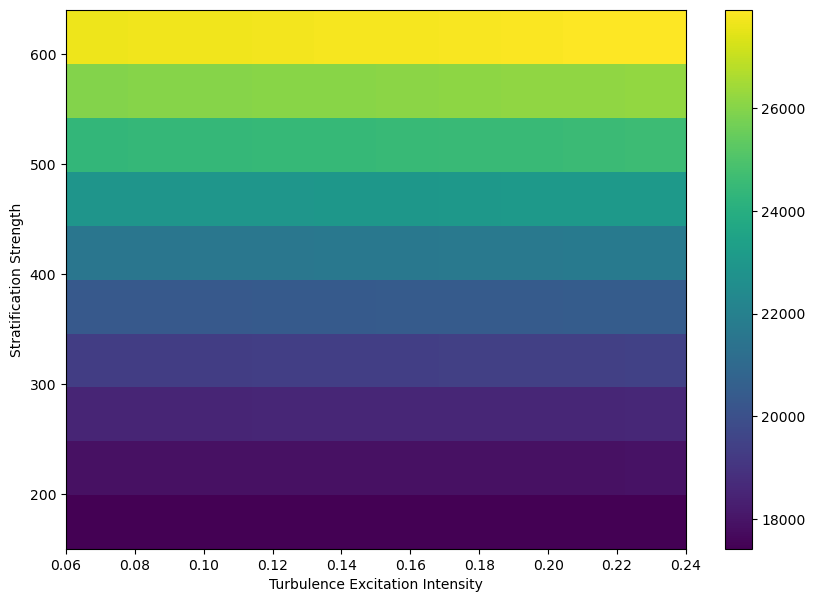

In [134]:
epsilon_values = np.linspace(0.06, 0.24, 10)
N_0_squared_values = np.linspace(150, 640, 10)
x, y = epsilon_values, N_0_squared_values
# x, y = (epsilon_values - np.min(epsilon_values)) / (np.max(epsilon_values) - np.min(epsilon_values)), (N_0_squared_values - np.min(N_0_squared_values)) / (np.max(N_0_squared_values) - np.min(N_0_squared_values))
z = np.array(stabilityStat).reshape(len(epsilon_values), len(N_0_squared_values))
z = z.T

fig = plt.figure(figsize=(10, 7))
plt.imshow(z, extent=[x.min(), x.max(), y.min(), y.max()],origin='lower', aspect='auto', cmap='viridis')

plt.xlabel('Turbulence Excitation Intensity')
plt.ylabel('Stratification Strength')
plt.colorbar()

plt.show()

In [131]:
z

array([[17424.12245951, 17425.79889395, 17427.58632514, 17429.47781831,
        17431.47030952, 17433.56221856, 17435.75262943, 17438.04095853,
        17440.42680302, 17442.90986481],
       [17879.73388169, 17883.46970104, 17887.42571512, 17891.57286269,
        17895.89801772, 17900.39435767, 17905.05792906, 17909.88622859,
        17914.87754741, 17920.03064027],
       [18509.99134432, 18516.65641414, 18523.71864888, 18531.0969855 ,
        18538.75366432, 18546.66880073, 18554.83083512, 18563.23247491,
        18571.86878733, 18580.73622702],
       [19329.22972148, 19339.38481591, 19350.19774094, 19361.49684453,
        19373.19908653, 19385.25996073, 19397.65343613, 19410.36312045,
        19423.37801489, 19436.69031889],
       [20340.917816  , 20354.62975612, 20369.34045881, 20384.75366593,
        20400.71971633, 20417.15662508, 20434.01599132, 20451.26731141,
        20468.89023694, 20486.87049974],
       [21534.68727657, 21551.55157526, 21569.81112374, 21589.02876956,
   

Comparison to the grid data

In [22]:
z.min()

17424.122459511582

In [23]:
Eigenvalues90

{-2.0 - 16.9669511535006*I: 1,
 -2.0 + 16.9669511535006*I: 1,
 -2.0 - 9.4633356081941*I: 1,
 -2.0 + 9.4633356081941*I: 1,
 -1.99863777058245 - 26.522214819026*I: 1,
 -1.99863777058245 + 26.522214819026*I: 1,
 -1.9534196572004 - 17.5127441038743*I: 1,
 -0.370218189165144 - 9.55229726515369*I: 1,
 -2.3135772722923 - 8.94320520891369*I: 1,
 -1.9534196572004 + 17.5127441038743*I: 1,
 -2.82829422151942 - 6.56783364715292e-61*I: 1,
 -2.0 + 4.92412256422902e-63*I: 1,
 -2.0 - 2.53437336684871e-63*I: 1,
 -2.0 - 4.0932941844741e-29*I: 1,
 -2.0 + 4.0932941844741e-29*I: 1,
 -2.3135772722923 + 8.94320520891369*I: 1,
 -0.370218189165144 + 9.55229726515369*I: 1}

Running simulation 0


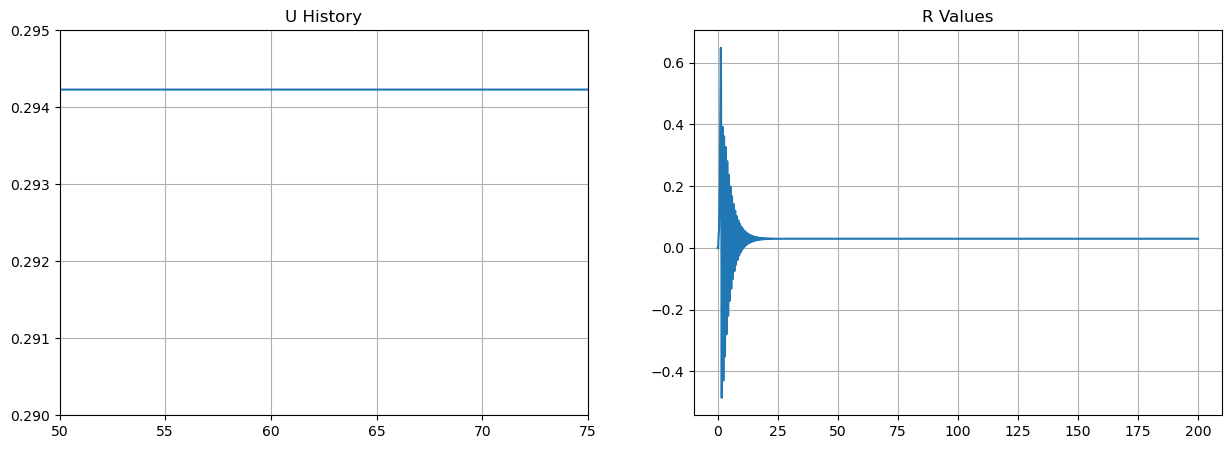

[0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986
 0.29422986 0.29422986 0.29422986 0.29422986 0.29422986 0.2942

In [24]:
class SimulationSSD:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m    
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = 0.01
        self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):

            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

    def make_plots(self):

        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_History)
        axs[0].set_title(f"U History")
        axs[0].grid()
        axs[0].set_xlim(50, 75)
        axs[0].set_ylim(.29, .295)
        axs[1].plot(time_array, self.R_History)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    epsilon_values = [.24]
    N_0_squared_values = [150]
    combo_list = list(itertools.product(epsilon_values, N_0_squared_values))

    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 200
    simulations = []
    for idx, (epsilon, N_0_squared) in enumerate(combo_list):
        print(f"Running simulation {idx}")
        sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
        sim.simulate()
        simulations.append(sim)
        globals()[f'sim{idx}'] = sim
        globals()[f'sim{idx}Ustar'] = sim.U_History[-1]
        globals()[f'sim{idx}Cstar'] = sim.C_History[-1]
        sim.make_plots()
        print(sim.U_History[-100:])

In [25]:
Eigenvalues90

{-2.0 - 16.9669511535006*I: 1,
 -2.0 + 16.9669511535006*I: 1,
 -2.0 - 9.4633356081941*I: 1,
 -2.0 + 9.4633356081941*I: 1,
 -1.99863777058245 - 26.522214819026*I: 1,
 -1.99863777058245 + 26.522214819026*I: 1,
 -1.9534196572004 - 17.5127441038743*I: 1,
 -0.370218189165144 - 9.55229726515369*I: 1,
 -2.3135772722923 - 8.94320520891369*I: 1,
 -1.9534196572004 + 17.5127441038743*I: 1,
 -2.82829422151942 - 6.56783364715292e-61*I: 1,
 -2.0 + 4.92412256422902e-63*I: 1,
 -2.0 - 2.53437336684871e-63*I: 1,
 -2.0 - 4.0932941844741e-29*I: 1,
 -2.0 + 4.0932941844741e-29*I: 1,
 -2.3135772722923 + 8.94320520891369*I: 1,
 -0.370218189165144 + 9.55229726515369*I: 1}

Running simulation 0


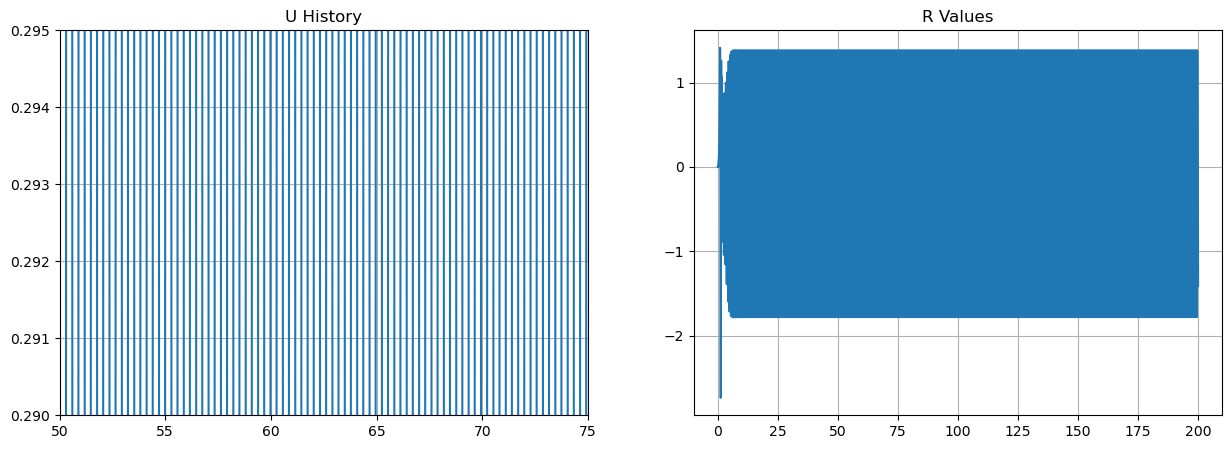

[0.38778222 0.38783198 0.38787089 0.38789881 0.38791558 0.38792108
 0.38791515 0.38789764 0.38786842 0.38782735 0.38777428 0.38770906
 0.38763157 0.38754166 0.38743919 0.38732402 0.38719602 0.38705506
 0.38690099 0.38673368 0.38655301 0.38635884 0.38615104 0.38592948
 0.38569405 0.3854446  0.38518103 0.38490321 0.38461102 0.38430434
 0.38398306 0.38364707 0.38329625 0.38293049 0.38254969 0.38215374
 0.38174255 0.381316   0.38087401 0.38041648 0.37994331 0.37945443
 0.37894973 0.37842914 0.37789258 0.37733997 0.37677123 0.3761863
 0.37558511 0.37496758 0.37433366 0.37368329 0.37301642 0.372333
 0.37163297 0.37091629 0.37018293 0.36943284 0.368666   0.36788237
 0.36708193 0.36626466 0.36543055 0.36457957 0.36371173 0.36282702
 0.36192544 0.36100699 0.36007169 0.35911954 0.35815057 0.3571648
 0.35616226 0.35514298 0.35410699 0.35305434 0.35198508 0.35089925
 0.34979692 0.34867814 0.34754298 0.34639152 0.34522383 0.34403999
 0.3428401  0.34162423 0.3403925  0.339145   0.33788184 0.33660313

In [26]:
class SimulationSSD:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m    
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = 0.01
        self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):

            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

    def make_plots(self):

        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_History)
        axs[0].set_title(f"U History")
        axs[0].grid()
        axs[0].set_xlim(50, 75)
        axs[0].set_ylim(.29, .295)
        axs[1].plot(time_array, self.R_History)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    epsilon_values = [.5]
    N_0_squared_values = [150]
    combo_list = list(itertools.product(epsilon_values, N_0_squared_values))

    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 200
    simulations = []
    for idx, (epsilon, N_0_squared) in enumerate(combo_list):
        print(f"Running simulation {idx}")
        sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
        sim.simulate()
        simulations.append(sim)
        globals()[f'sim{idx}'] = sim
        globals()[f'sim{idx}Ustar'] = sim.U_History[-1]
        globals()[f'sim{idx}Cstar'] = sim.C_History[-1]
        sim.make_plots()
        print(sim.U_History[-100:])

In [27]:
sim0Ustar

0.32298996191311363

In [28]:
sim0Cstar

array([[ 3.45414593e-04, -5.50990758e-02, -4.15949064e-05,
        -8.62186677e-03],
       [-5.50990758e-02,  8.27339894e+01,  2.24041164e-02,
        -3.08242583e+01],
       [-4.15949064e-05,  2.24041164e-02,  8.22320326e-05,
        -3.80846829e-02],
       [-8.62186677e-03, -3.08242583e+01, -3.80846829e-02,
         5.39519326e+01]])

In [29]:
combo_list = [(.5, 150)]
for idx in range(len(combo_list)):
    print(f"Calculating eigenvalues for simulation {idx}")
    U_star_val = globals()[f'sim{idx}Ustar']
    C_star_val = globals()[f'sim{idx}Cstar']
    epsilon_val, N_0_squared_val = combo_list[idx]

    C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)}
    subs_dict = {'U_star': U_star_val, **C_star_subs}

    subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
    A_subs = A.subs(subs_dict)
    # A_numeric = np.array(A_subs).astype(np.complex128)
    # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
    eigenvalues = A_subs.eigenvals()
    globals()[f'Eigenvalues{idx}'] = eigenvalues


Calculating eigenvalues for simulation 0


In [30]:
C_star_val

array([[ 3.45414593e-04, -5.50990758e-02, -4.15949064e-05,
        -8.62186677e-03],
       [-5.50990758e-02,  8.27339894e+01,  2.24041164e-02,
        -3.08242583e+01],
       [-4.15949064e-05,  2.24041164e-02,  8.22320326e-05,
        -3.80846829e-02],
       [-8.62186677e-03, -3.08242583e+01, -3.80846829e-02,
         5.39519326e+01]])

In [31]:
U_star_val

0.32298996191311363

In [32]:
C_star_subs

{'C_star0': 0.0003454145932476131,
 'C_star1': -0.055099075760778236,
 'C_star2': -4.1594906400123084e-05,
 'C_star3': -0.00862186677121238,
 'C_star4': -0.055099075760778236,
 'C_star5': 82.7339894380509,
 'C_star6': 0.022404116371334222,
 'C_star7': -30.824258323650223,
 'C_star8': -4.1594906400123084e-05,
 'C_star9': 0.022404116371334222,
 'C_star10': 8.223203259474443e-05,
 'C_star11': -0.038084682895708634,
 'C_star12': -0.00862186677121238,
 'C_star13': -30.824258323650223,
 'C_star14': -0.038084682895708634,
 'C_star15': 53.95193256897486}

In [33]:
for i in Eigenvalues0:
    print(i)

-2.0 - 16.8368431066934*I
-2.0 - 10.288336428196*I
-2.0 + 16.8368431066934*I
-2.0 + 10.288336428196*I
-1.95532370945806 - 27.2952245156784*I
-1.95532370945806 + 27.2952245156784*I
-1.28587178288161 - 17.2122342680469*I
0.171766048174407 - 12.989373068527*I
-1.62706416348009 - 8.97574434388391*I
-6.70701278470928 - 5.84428070205244e-62*I
-2.0 + 5.03875117886861e-60*I
-2.0 - 5.03935818336551e-60*I
-2.0 - 5.56043782968443e-54*I
-2.0 + 5.5604376609087e-54*I
-1.28587178288161 + 17.2122342680469*I
-1.62706416348009 + 8.97574434388391*I
0.171766048174407 + 12.989373068527*I


Running simulation 0


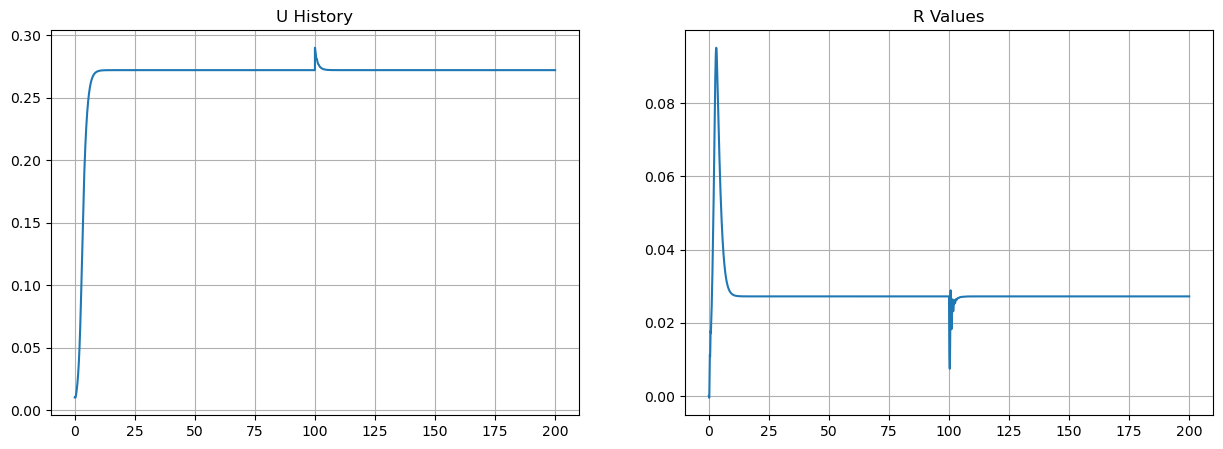

In [34]:
class SimulationSSD:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m    
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = 0.01
        self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):
            if i == 100000:
                self.U = 0.29


            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

    def make_plots(self):

        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_History)
        axs[0].set_title(f"U History")
        axs[0].grid()
        # axs[0].set_xlim(50, 75)
        # axs[0].set_ylim(.29, .295)
        axs[1].plot(time_array, self.R_History)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    # epsilon_values = [.24]
    epsilon_values = [.06]
    N_0_squared_values = [150]
    combo_list = list(itertools.product(epsilon_values, N_0_squared_values))

    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 200
    simulations = []
    for idx, (epsilon, N_0_squared) in enumerate(combo_list):
        print(f"Running simulation {idx}")
        sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
        sim.simulate()
        simulations.append(sim)
        globals()[f'sim{idx}'] = sim
        globals()[f'sim{idx}Ustar'] = sim.U_History[-1]
        globals()[f'sim{idx}Cstar'] = sim.C_History[-1]
        sim.make_plots()

In [35]:
combo_list = [(.5, 150)]
for idx in range(len(combo_list)):
    print(f"Calculating eigenvalues for simulation {idx}")
    U_star_val = globals()[f'sim{idx}Ustar']
    C_star_val = globals()[f'sim{idx}Cstar']
    epsilon_val, N_0_squared_val = combo_list[idx]

    C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)}
    subs_dict = {'U_star': U_star_val, **C_star_subs}

    subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
    A_subs = A.subs(subs_dict)
    # A_numeric = np.array(A_subs).astype(np.complex128)
    # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
    eigenvalues = A_subs.eigenvals()
    globals()[f'Eigenvalues{idx}'] = eigenvalues


Calculating eigenvalues for simulation 0


In [36]:
k/k_e_square

0.02122065907891938

In [37]:
A_subs

Matrix([
[                -2, 0.0212206590789194,  -9.91577007438069,                    0, 0.0212206590789194,                  0,                  0,                    0,  -9.91577007438069,                  0,                 0,                    0,                    0,                    0,                    0,                    0,  -5.85712087885119e-5],
[ -5654.86677646163,                 -2,                  0,     5.12884659019691,                  0, 0.0212206590789194,                  0,                    0,                  0,  -9.91577007438069,                 0,                    0,                    0,                    0,                    0,                    0,    -0.167011067318076],
[-0.150848429123438,                  0,                 -2, -0.00702154160699538,                  0,                  0, 0.0212206590789194,                    0,                  0,                  0, -9.91577007438069,                    0,                    0,        

In [38]:
C_star_val

array([[ 4.02752423e-05, -4.09276821e-03,  8.03611845e-07,
        -3.91546822e-03],
       [-4.09276821e-03,  1.24882202e+01,  2.55762625e-03,
        -2.07762869e+00],
       [ 8.03611845e-07,  2.55762625e-03,  7.47137706e-06,
        -1.08132958e-03],
       [-3.91546822e-03, -2.07762869e+00, -1.08132958e-03,
         4.54106411e+00]])

In [39]:
U_star_val

0.27209376239661676

In [40]:
for i in eigenvalues:
    print(i)

-2.0 - 17.0389093987126*I
-2.0 + 17.0389093987126*I
-2.0 - 8.87163509288763*I
-2.0 + 8.87163509288763*I
-1.99973440102461 - 25.933489371327*I
-1.99973440102461 + 25.933489371327*I
-1.99519437941151 - 17.1778421677398*I
-1.99519437941151 + 17.1778421677398*I
-2.05505520137256 - 8.65252671757401*I
-1.5761665372713 - 8.5800477389102*I
-2.05505520137256 + 8.65252671757401*I
-1.5761665372713 + 8.5800477389102*I
-0.847698961840011 - 6.5784061454245e-62*I
-2.0 + 1.62385280966733e-59*I
-2.0 - 1.6238947803141e-59*I
-2.0 - 2.3650871330781e-29*I
-2.0 + 2.3650871330781e-29*I


In [41]:
print(sim0Ustar)

0.27209376239661676


In [42]:
print(stabilityStat[0])

17424.122459511582


In [43]:
decayU = sim0.U_History[100000:105000]
decayU[-1]


0.2723210235044649

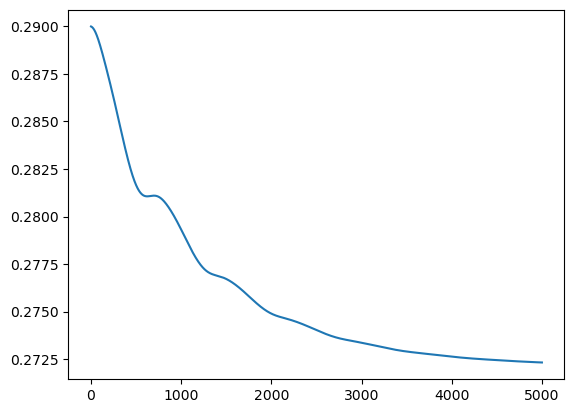

In [44]:
plt.plot(decayU)

In [45]:
decayU = decayU - sim0Ustar


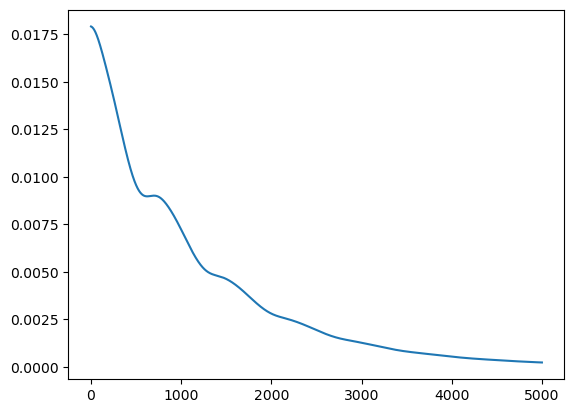

In [46]:

plt.plot(decayU)

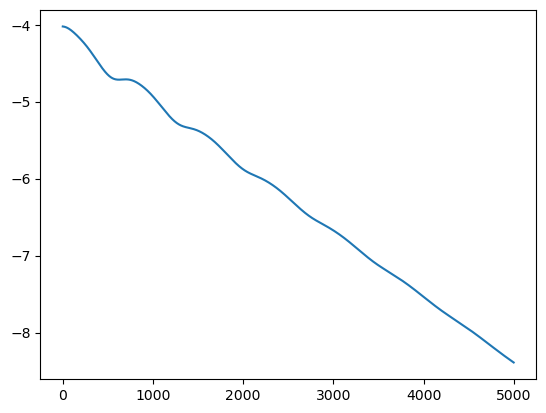

In [47]:
plt.plot(np.log(decayU))

In [48]:
slope, intercept, r_value, p_value, std_err = linregress(np.arange(0, len(decayU)), np.log(decayU))
slope

-0.0008583739897081791

In [49]:
intercept

-4.1081071583523165

Checking for steps

In [50]:
combo_list = [(.5, 150)]
for idx in range(len(combo_list)):
    print(f"Calculating eigenvalues for simulation {idx}")
    U_star_val = globals()[f'sim{idx}Ustar']
    C_star_val = globals()[f'sim{idx}Cstar']
    epsilon_val, N_0_squared_val = combo_list[idx]

    C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)}
    subs_dict = {'U_star': U_star_val, **C_star_subs}

    subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
    A_subs = A.subs(subs_dict)
    # A_numeric = np.array(A_subs).astype(np.complex128)
    # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
    eigenvalues = A_subs.eigenvals()
    globals()[f'Eigenvalues{idx}'] = eigenvalues


Calculating eigenvalues for simulation 0


In [51]:
decayU = sim0.U_History[100000:105000]
decayU[-1]

0.2723210235044649

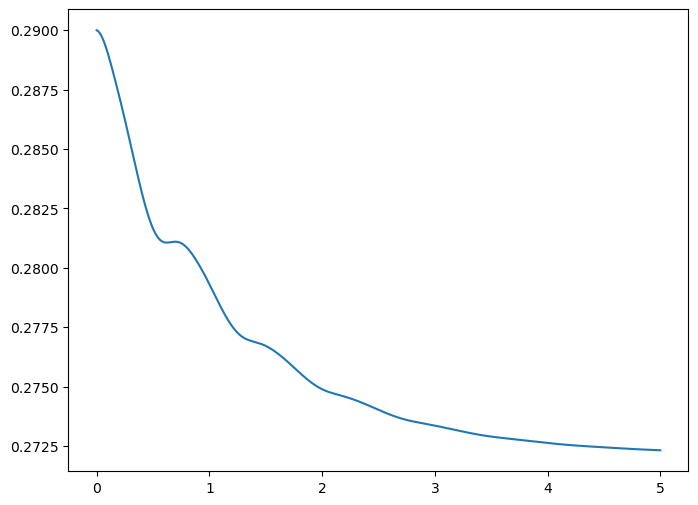

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
decay_range = np.arange(0, len(decayU)*dt_val, dt_val)
ax.plot(decay_range, decayU)
plt.show()

In [53]:
decayU = decayU - sim0Ustar

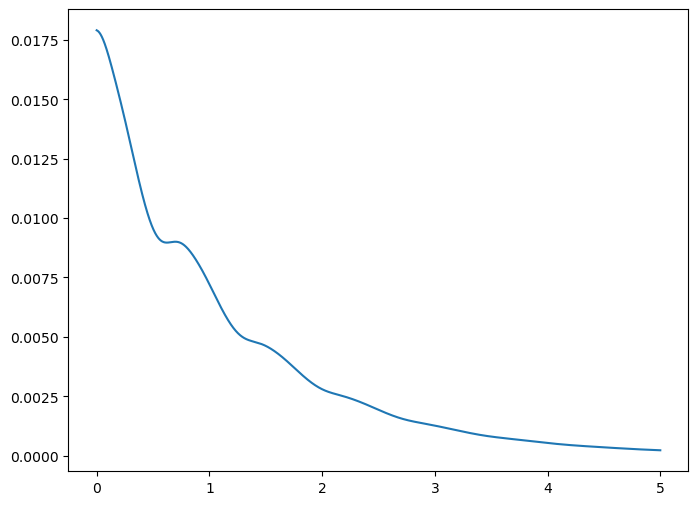

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
decay_range = np.arange(0, len(decayU)*dt_val, dt_val)
ax.plot(decay_range, decayU)
plt.show()

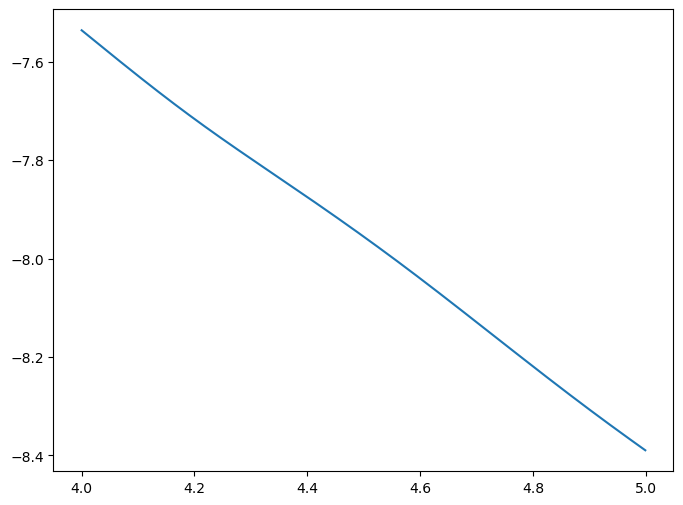

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
decay_range = np.arange(0, len(decayU)*dt_val, dt_val)
ax.plot(decay_range[4000:], np.log(decayU[4000:]))
plt.show()

In [56]:
slope, intercept, r_value, p_value, std_err = linregress(decay_range[4000:], np.log(decayU[4000:]))
slope

-0.8448846746503549

In [57]:
std_err

0.0005497914476877172

In [58]:
intercept

-4.161251084304571

In [59]:
stabilityStat

[17424.122459511582,
 17879.73388169468,
 18509.99134431758,
 19329.229721482985,
 20340.91781600212,
 21534.68727656517,
 22888.940396513648,
 24376.864277415014,
 25972.011845810244,
 27651.45302308802,
 17425.79889394907,
 17883.469701044694,
 18516.65641414478,
 19339.38481591444,
 20354.629756116134,
 21551.551575261405,
 22908.277573694366,
 24397.943001878786,
 25994.191829480904,
 27674.23644754667,
 17427.586325136712,
 17887.425715117864,
 18523.71864887888,
 19350.19774093981,
 20369.340458813822,
 21569.81112373587,
 22929.426187526005,
 24421.23538886851,
 26018.95024284346,
 27699.913440453663,
 17429.477818305077,
 17891.572862693756,
 18531.09698550242,
 19361.49684452756,
 20384.75366593045,
 21589.028769561493,
 22951.81403785311,
 24446.057235341417,
 26045.52242347903,
 27727.671441582992,
 17431.4703095208,
 17895.898017715634,
 18538.75366431951,
 19373.199086532208,
 20400.719716333366,
 21608.97298723117,
 22975.122602695574,
 24472.007765136084,
 26073.43707214

More detailed analysis on .24 150

Running simulation 0


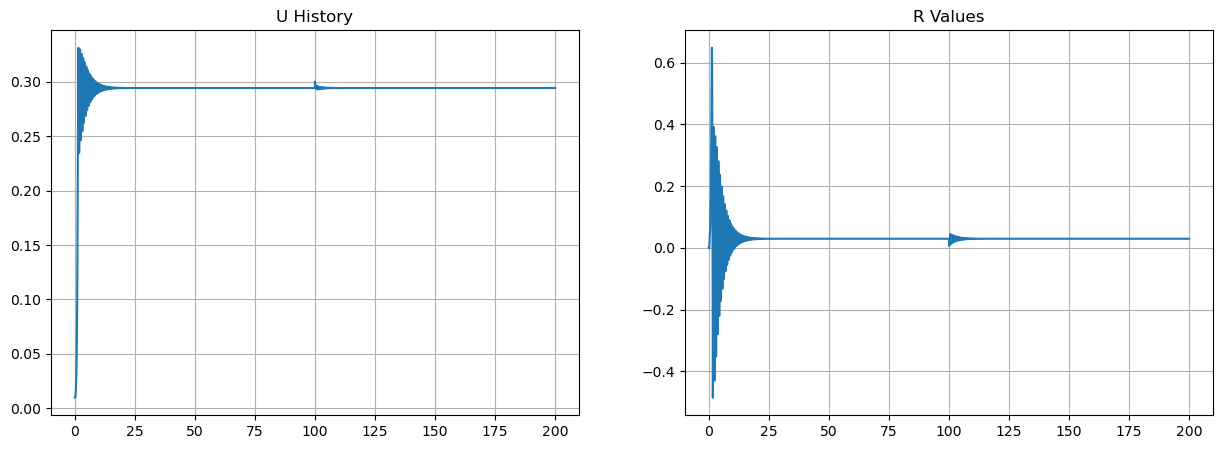

In [60]:
class SimulationSSD:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m    
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = 0.01
        self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):
            if i == 100000:
                self.U = 0.3


            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

    def make_plots(self):

        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_History)
        axs[0].set_title(f"U History")
        axs[0].grid()
        # axs[0].set_xlim(50, 75)
        # axs[0].set_ylim(.29, .295)
        axs[1].plot(time_array, self.R_History)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    epsilon_values = [.24]
    # epsilon_values = [.06]
    N_0_squared_values = [150]
    combo_list = list(itertools.product(epsilon_values, N_0_squared_values))

    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 200
    simulations = []
    for idx, (epsilon, N_0_squared) in enumerate(combo_list):
        print(f"Running simulation {idx}")
        sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
        sim.simulate()
        simulations.append(sim)
        globals()[f'sim{idx}'] = sim
        globals()[f'sim{idx}Ustar'] = sim.U_History[-1]
        globals()[f'sim{idx}Cstar'] = sim.C_History[-1]
        sim.make_plots()

In [61]:
combo_list = [(.24, 150)]
for idx in range(len(combo_list)):
    print(f"Calculating eigenvalues for simulation {idx}")
    U_star_val = globals()[f'sim{idx}Ustar']
    C_star_val = globals()[f'sim{idx}Cstar']
    epsilon_val, N_0_squared_val = combo_list[idx]

    C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)}
    subs_dict = {'U_star': U_star_val, **C_star_subs}

    subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
    A_subs = A.subs(subs_dict)
    # A_numeric = np.array(A_subs).astype(np.complex128)
    # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
    eigenvalues = A_subs.eigenvals()
    globals()[f'Eigenvalues{idx}'] = eigenvalues


Calculating eigenvalues for simulation 0


In [62]:
U_star_val

0.29422985769340126

In [63]:
for i in eigenvalues:
    print(i)

-2.0 - 16.9669511535006*I
-2.0 + 16.9669511535006*I
-2.0 - 9.4633356081942*I
-2.0 + 9.4633356081942*I
-1.99863777058245 - 26.5222148190261*I
-1.99863777058245 + 26.5222148190261*I
-1.9534196572004 - 17.5127441038743*I
-0.370218189165104 - 9.55229726515373*I
-2.3135772722923 - 8.94320520891372*I
-1.9534196572004 + 17.5127441038743*I
-2.82829422151951 + 6.47014945375121e-62*I
-2.0 + 6.20592037494487e-60*I
-2.0 - 6.19835010360736e-60*I
-2.0 - 7.02652562794693e-29*I
-2.0 + 7.02652562794693e-29*I
-2.3135772722923 + 8.94320520891372*I
-0.370218189165104 + 9.55229726515373*I


In [64]:
sim90Ustar

0.29422985769339766

In [65]:
stabilityStat[90]

17442.909864811463

In [66]:
decayU = sim0.U_History[100000:120000]
decayU[-1]


0.2942288077267042

In [67]:
decayU[-100:]

array([0.29423171, 0.29423168, 0.29423166, 0.29423163, 0.2942316 ,
       0.29423158, 0.29423155, 0.29423152, 0.2942315 , 0.29423147,
       0.29423144, 0.29423141, 0.29423139, 0.29423136, 0.29423133,
       0.2942313 , 0.29423127, 0.29423125, 0.29423122, 0.29423119,
       0.29423116, 0.29423113, 0.2942311 , 0.29423107, 0.29423104,
       0.29423102, 0.29423099, 0.29423096, 0.29423093, 0.2942309 ,
       0.29423087, 0.29423084, 0.29423081, 0.29423078, 0.29423075,
       0.29423072, 0.29423069, 0.29423066, 0.29423063, 0.2942306 ,
       0.29423057, 0.29423054, 0.29423051, 0.29423048, 0.29423045,
       0.29423042, 0.29423039, 0.29423036, 0.29423033, 0.2942303 ,
       0.29423027, 0.29423024, 0.29423021, 0.29423018, 0.29423014,
       0.29423011, 0.29423008, 0.29423005, 0.29423002, 0.29422999,
       0.29422996, 0.29422993, 0.2942299 , 0.29422987, 0.29422984,
       0.29422981, 0.29422978, 0.29422975, 0.29422972, 0.29422969,
       0.29422966, 0.29422963, 0.2942296 , 0.29422957, 0.29422

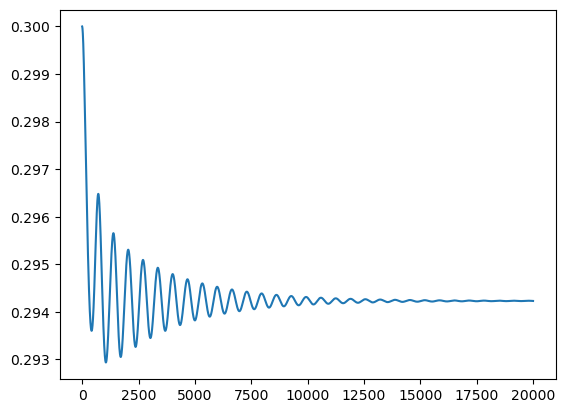

In [68]:
plt.plot(decayU)

In [69]:
decayU = decayU - sim90Ustar

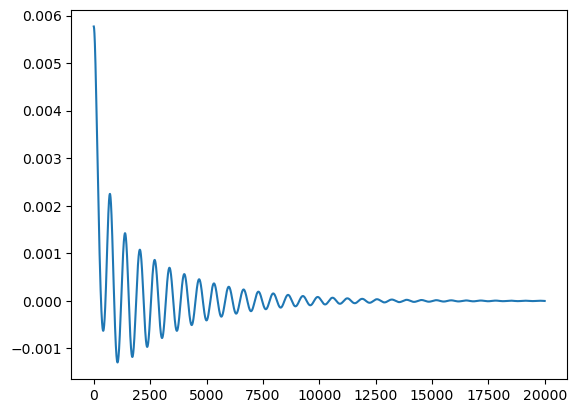

In [70]:
plt.plot(decayU)

/tmp/ipykernel_10246/284651738.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.log(decayU))


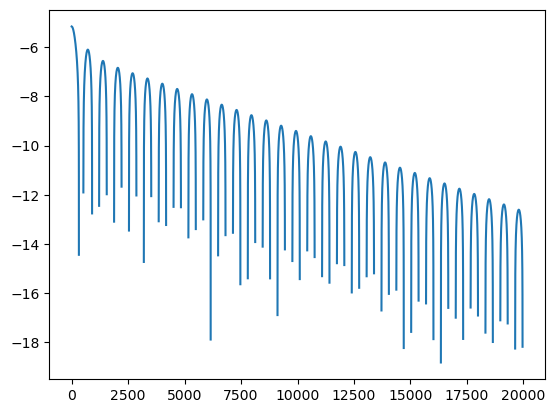

In [71]:
plt.plot(np.log(decayU))

In [72]:
slope, intercept, r_value, p_value, std_err = linregress(np.arange(0, len(decayU)), np.log(decayU))
slope

/tmp/ipykernel_10246/2397472033.py:1: RuntimeWarning: invalid value encountered in log
  slope, intercept, r_value, p_value, std_err = linregress(np.arange(0, len(decayU)), np.log(decayU))


nan

In [73]:
intercept

nan

Checking if Normal

Running simulation 0


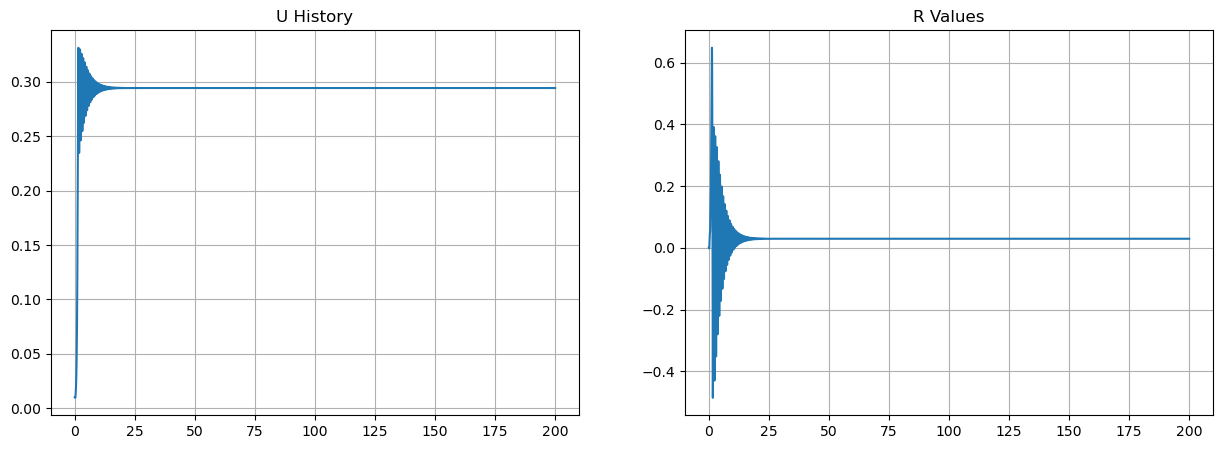

In [74]:
class SimulationSSD:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m    
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = 0.01
        self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):
            # if i == 100000:
            #     self.U = 0.3


            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

    def make_plots(self):

        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_History)
        axs[0].set_title(f"U History")
        axs[0].grid()
        # axs[0].set_xlim(50, 75)
        # axs[0].set_ylim(.29, .295)
        axs[1].plot(time_array, self.R_History)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    epsilon_values = [.24]
    # epsilon_values = [.06]
    N_0_squared_values = [150]
    combo_list = list(itertools.product(epsilon_values, N_0_squared_values))

    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 200
    simulations = []
    for idx, (epsilon, N_0_squared) in enumerate(combo_list):
        print(f"Running simulation {idx}")
        sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
        sim.simulate()
        simulations.append(sim)
        globals()[f'sim{idx}'] = sim
        globals()[f'sim{idx}Ustar'] = sim.U_History[-1]
        globals()[f'sim{idx}Cstar'] = sim.C_History[-1]
        sim.make_plots()

In [75]:
combo_list = [(.24, 150)]
for idx in range(len(combo_list)):
    # print(f"Calculating eigenvalues for simulation {idx}")
    U_star_val = globals()[f'sim{idx}Ustar']
    C_star_val = globals()[f'sim{idx}Cstar']
    epsilon_val, N_0_squared_val = combo_list[idx]

    C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)}
    subs_dict = {'U_star': U_star_val, **C_star_subs}

    subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
    A_subs = A.subs(subs_dict)
    # A_numeric = np.array(A_subs).astype(np.complex128)
    # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
    # eigenvalues = A_subs.eigenvals()
    # globals()[f'Eigenvalues{idx}'] = eigenvalues
A_subs

Matrix([
[                -2, 0.0212206590789194,  -10.7224641689976,                    0, 0.0212206590789194,                  0,                  0,                    0,  -10.7224641689976,                  0,                 0,                    0,                    0,                    0,                    0,                    0, -6.33362495156113e-5],
[ -5654.86677646163,                 -2,                  0,     5.54610215637809,                  0, 0.0212206590789194,                  0,                    0,                  0,  -10.7224641689976,                 0,                    0,                    0,                    0,                    0,                    0,   -0.806590311121669],
[-0.163120651658179,                  0,                 -2, -0.00702154160699538,                  0,                  0, 0.0212206590789194,                    0,                  0,                  0, -10.7224641689976,                    0,                    0,          

In [76]:
A_subs.eigenvals()

{-2.0 - 16.9669511535006*I: 1,
 -2.0 + 16.9669511535006*I: 1,
 -2.0 - 9.4633356081941*I: 1,
 -2.0 + 9.4633356081941*I: 1,
 -1.99863777058245 - 26.522214819026*I: 1,
 -1.99863777058245 + 26.522214819026*I: 1,
 -1.9534196572004 - 17.5127441038743*I: 1,
 -0.370218189165144 - 9.55229726515369*I: 1,
 -2.3135772722923 - 8.94320520891369*I: 1,
 -1.9534196572004 + 17.5127441038743*I: 1,
 -2.82829422151942 - 6.56783364715292e-61*I: 1,
 -2.0 + 4.92412256422902e-63*I: 1,
 -2.0 - 2.53437336684871e-63*I: 1,
 -2.0 - 4.0932941844741e-29*I: 1,
 -2.0 + 4.0932941844741e-29*I: 1,
 -2.3135772722923 + 8.94320520891369*I: 1,
 -0.370218189165144 + 9.55229726515369*I: 1}

In [77]:
def power_method(A, num_steps=100):
    """
    Computes the dominant eigenvalue and eigenvector of matrix A using the power method.
    
    Parameters:
        A (numpy.ndarray): The matrix for which we compute the dominant eigenpair.
        num_steps (int): The number of iterations to perform.
    
    Returns:
        eigenvalue (float): Estimated dominant eigenvalue.
        eigenvector (numpy.ndarray): Estimated dominant eigenvector.
    """
    n = A.shape[0]
    v = np.random.rand(n).astype(np.float64)  # Start with a random vector
    v = v / np.linalg.norm(v)  # Normalize
    
    for _ in range(num_steps):
        v = A @ v  # Matrix-vector multiplication
        # vnorm = np.sqrt(np.dot(v,v))
        v = v / np.linalg.norm(v)  # Normalize
        # v = v / vnorm  # Normalize

    # Compute the estimated eigenvalue using the Rayleigh quotient
    eigenvalue = (v @ A @ v) / (v @ v)
    
    return eigenvalue, v



In [78]:
np.random.seed(None)

In [79]:
A_subs_np = np.array(A_subs).astype(np.float64)

In [80]:
np.linalg.eig(A_subs_np)

EigResult(eigenvalues=array([-1.99863777+26.52221482j, -1.99863777-26.52221482j,
       -1.95341966+17.5127441j , -1.95341966-17.5127441j ,
       -0.37021819 +9.55229727j, -0.37021819 -9.55229727j,
       -2.31357727 +8.94320521j, -2.31357727 -8.94320521j,
       -2.82829422 +0.j        , -2.        +16.96695115j,
       -2.        -16.96695115j, -2.         +9.46333561j,
       -2.         -9.46333561j, -1.99999992 +0.j        ,
       -2.00000008 +0.j        , -2.         +0.j        ,
       -2.         +0.j        ]), eigenvectors=array([[-2.53633395e-06+2.57827773e-08j, -2.53633395e-06-2.57827773e-08j,
         2.43162329e-06+1.62913209e-07j,  2.43162329e-06-1.62913209e-07j,
        -4.02134364e-07+7.11259117e-07j, -4.02134364e-07-7.11259117e-07j,
        -4.79424486e-07-1.97501658e-06j, -4.79424486e-07+1.97501658e-06j,
        -1.34392693e-06+0.00000000e+00j, -1.97989584e-06-1.47869567e-20j,
        -1.97989584e-06+1.47869567e-20j,  1.79155297e-06-1.51773925e-20j,
         1.791

In [81]:
# Example usage
eigval, eigvec = power_method(A_subs_np, num_steps=10000)
print("Estimated Eigenvalue:", eigval)
print("Estimated Eigenvector:", eigvec)

Estimated Eigenvalue: -7.800727968965466
Estimated Eigenvector: [ 2.93787237e-06 -9.11486928e-04  2.54063198e-07 -8.81709503e-04
 -9.11486928e-04 -8.84312525e-01  2.46120856e-04  2.77420194e-01
  2.54063198e-07  2.46120856e-04 -5.70858374e-08 -7.01712732e-05
 -8.81709503e-04  2.77420194e-01 -7.01712732e-05  2.53108081e-01
 -6.17769228e-04]


In [82]:
def complex_power_method(A, num_steps=100):
    """
    Power method adapted for complex eigenvalues.
    """
    A = np.array(A, dtype=np.complex128)  # Ensure complex arithmetic
    n = A.shape[0]
    v = np.random.randn(n) + 1j * np.random.randn(n)  # Complex initial vector
    v /= np.linalg.norm(v)

    for _ in range(num_steps):
        v = A @ v
        v /= np.linalg.norm(v)  # Normalize

    eigenvalue = np.dot(v.conj().T, A @ v) / np.dot(v.conj().T, v)  # Rayleigh quotient

    return eigenvalue, v


In [83]:


eigval, eigvec = complex_power_method(A_subs_np,num_steps=1000)

print("Estimated Eigenvalue:", eigval)
print("Estimated Eigenvector:", eigvec)


Estimated Eigenvalue: (-2.6671697386148145-19.33255837467575j)
Estimated Eigenvector: [-1.06785555e-06-6.09141827e-07j -6.48390575e-04+2.02453660e-03j
  1.91156679e-07-5.83845999e-07j  3.13071968e-04+1.96700022e-04j
 -6.48390575e-04+2.02453660e-03j  3.26959179e-01+1.72993522e-01j
 -8.73061321e-05-5.50660952e-05j  2.00038634e-01-6.21236329e-01j
  1.91156679e-07-5.83845999e-07j -8.73061321e-05-5.50660952e-05j
  2.15589180e-08+1.03197570e-08j -4.78854652e-05+1.52054315e-04j
  3.13071968e-04+1.96700022e-04j  2.00038634e-01-6.21236329e-01j
 -4.78854652e-05+1.52054315e-04j -9.68057932e-02-4.34747617e-02j
  1.92347681e-04+1.88415849e-04j]


In [84]:
A_subs_np.shape

(17, 17)

In [85]:
n = A_subs_np.shape[0]
v = np.random.randn(n)  # Start with a random vector
v = v / np.linalg.norm(v)  # Normalize

In [86]:
v

array([ 0.0446629 ,  0.08863438, -0.10606516,  0.18023242,  0.11832188,
        0.19938109,  0.16642876,  0.21952967, -0.09192777, -0.00382108,
        0.60580698,  0.0442706 , -0.49898322, -0.16127349, -0.18859884,
        0.22094499,  0.28277913])

In [87]:
np.dot(v,v)

1.0

In [88]:
v = np.random.randn(n)  # Start with a random vector
v = v/np.sqrt(np.dot(v,v))
v = A_subs_np @ v
v = v/np.sqrt(np.dot(v,v))
v

array([ 4.05304495e-04,  7.64330267e-02, -1.34607608e-04, -1.58190240e-01,
        7.59502276e-02, -1.15516202e-01,  1.57925349e-01, -1.74664744e-02,
       -1.76421818e-04,  4.14130116e-02, -3.01892531e-05,  1.01799147e-01,
       -4.12305919e-02, -7.27026361e-02,  1.01653672e-01, -1.97875882e-02,
       -9.46037497e-01])

In [89]:
np.random.randn(n)

array([-0.36141718,  1.72548383, -1.16704988,  2.56046959,  2.92747842,
        0.50429758,  0.95903456, -0.25349719, -0.29201974, -0.5906611 ,
        0.94955643, -1.55407672,  0.87917736, -0.35663607,  2.17786283,
       -0.58452908,  0.10960463])

In [90]:
v

array([ 4.05304495e-04,  7.64330267e-02, -1.34607608e-04, -1.58190240e-01,
        7.59502276e-02, -1.15516202e-01,  1.57925349e-01, -1.74664744e-02,
       -1.76421818e-04,  4.14130116e-02, -3.01892531e-05,  1.01799147e-01,
       -4.12305919e-02, -7.27026361e-02,  1.01653672e-01, -1.97875882e-02,
       -9.46037497e-01])

In [91]:
A_subs_np[1,:]

array([-5.65486678e+03, -2.00000000e+00,  0.00000000e+00,  5.54610216e+00,
        0.00000000e+00,  2.12206591e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.07224642e+01,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -8.06590311e-01])

In [92]:
np.max(np.max(np.abs(A_subs_np)))

33858.8541348874

In [93]:
v = np.random.randn(n)    
for i in range(2):
        print(i)
        v = A_subs_np @ v  # Matrix-vector multiplication
        v = v/np.sqrt(np.dot(v,v))
        print('test2')
        #vnorm = np.sqrt(np.dot(v,v))
        #v = v / np.linalg.norm(v)  # Normalize
        #print('test')
        #v = v / vnorm  # Normalize


0
test2
1
test2


In [94]:

    # # Compute the estimated eigenvalue using the Rayleigh quotient
    # eigenvalue = (v @ A @ v) / (v @ v)a

In [95]:
A_subs_np

array([[-2.00000000e+00,  2.12206591e-02, -1.07224642e+01,
         0.00000000e+00,  2.12206591e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.07224642e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -6.33362495e-05],
       [-5.65486678e+03, -2.00000000e+00,  0.00000000e+00,
         5.54610216e+00,  0.00000000e+00,  2.12206591e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.07224642e+01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -8.06590311e-01],
       [-1.63120652e-01,  0.00000000e+00, -2.00000000e+00,
        -7.02154161e-03,  0.00000000e+00,  0.00000000e+00,
         2.12206591e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.07224642e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.4

In [96]:
# power_method(A_subs,100)

In [97]:
A = A_subs
A_T = A.T

A*A_T - A_T*A

Matrix([
[   -63954806.6288994, 5.10864047100767e-5,   8.93400624590868e-8,     -29271.7564384394, 5.10864047100767e-5,   0.0208329006451891,  5.58039755560458e-6,   0.0385612074088414,   8.93400624590868e-8,  5.58039755560458e-6,  6.10267392175956e-11,  1.76919080689934e-5,     -29271.7564384394,   0.0385612074088414,  1.76919080689934e-5,   -0.0208329006451919, -372172.672350328],
[ 5.10864047100767e-5,    115.595217440277,       32285.084109901,    -0.420735276861942,   0.650587931275368,     265.308033574522,    0.071066607023432,     491.078908508123,   0.00113775018917295,   0.0710666070234325,   7.77176549727331e-7,    0.225307335733355,    -0.420735276861942,    -28780.6774968937,    0.225307335733354,     -265.308033574522, -1860027.92020919],
[ 8.93400624590868e-8,     32285.084109901,     -1210377039.84614, -0.000735783156414982, 0.00113775018917295,    0.463971511740461, 0.000124281503303791,    0.858800317859078,   1.98970106168872e-6, 0.000124281502714712,    1.3591296976

In [98]:
M = 1/2 * (A + A_T)
M

Matrix([
[                -2.0,  -2827.42277790127, -5.44279241032791,                 0,  -2827.42277790127,                 0,                   0,                 0,     -5.44279241032791,                   0,                    0,                 0,                 0,                 0,                 0,                0,  -3.16681247578056e-5],
[   -2827.42277790127,               -2.0,                 0,                 0,                  0, -2827.42277790127,                   0,                 0,                     0,   -5.44279241032791,                    0,                 0,                 0,                 0,                 0,                0,    -0.403295155560835],
[   -5.44279241032791,                  0,              -2.0,  2827.42987746001,                  0,                 0,   -2827.42277790127,                 0,                     0,                   0,    -5.44279241032791,                 0,                 0,                 0,                 0,  

In [99]:
M.eigenvals()

{-5656.85527470295 - 3.90825640290704e-125*I: 1,
 5652.85527470295 + 2.94438912195155e-125*I: 1,
 -7.44279704064531 - 2.41330834424049e-125*I: 1,
 3.44279704064531 - 9.21582034776611e-126*I: 1,
 -2.0 + 2.61075927142431e-64*I: 1,
 -2.0 - 1.80208452430083e-61*I: 1,
 -2.0 + 1.80071901383249e-61*I: 1,
 -17445.0234068648: 1,
 -5660.63586047641: 1,
 -5653.07504699753: 1,
 -5.91880692305920: 1,
 1.91880688869625: 1,
 -3813.86551018088: 1,
 5656.63591818679: 1,
 5649.07498968258: 1,
 3809.87905187311: 1,
 17442.9098648115: 1}

In [100]:
#Perform analysis by varying only N0. This is because varying epsilon will actually change the strength of excitation in addition to a 
#fundamental parameter of the system. 

Running simulation 0


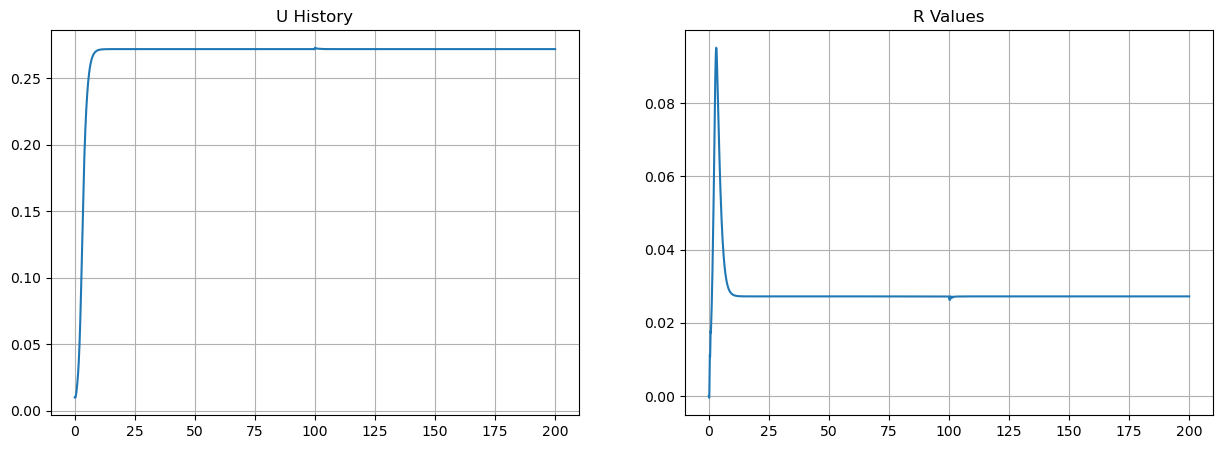

In [101]:
class SimulationSSD:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):

        #Make sure this is updated

        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m    
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2

        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]]) 
        self.U = 0.01
        self.C = np.array([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

        self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]])  
    
        self.Q = np.array([[8/self.k_e_square, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])
        self.R = 0
        self.C_History = np.zeros((self.num_steps, 4, 4))              
        # self.C_History = np.zeros(self.num_steps)
        self.U_History = np.zeros(self.num_steps)
        self.R_History = np.zeros(self.num_steps)
        self.C = self.C.astype(np.float64)

    def simulate(self):
        for i in range(self.num_steps):
            if i == 100000:
                self.U += 0.001


            self.A_U = np.array([[-1, (k / self.k_e_square), self.U*(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), self.U*0],
                             
                             [-k * N_0_squared, -1, self.U*0, self.U*self.k/2],

                             [self.U*(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), self.U*0, -1, -self.k/self.k_plus_square],

                             [self.U*0, self.U* -k / 2,k * N_0_squared, -1]]) 
                             
 
            C_dot = (self.A_U @ self.C + self.C @ np.transpose(self.A_U) + self.epsilon * self.Q) 
            U_dot = (self.R - self.r_m * self.U)

            
            self.C += C_dot * self.dt
            self.U += U_dot * self.dt
            self.R = 0.25 * self.k * (self.k_plus_square - self.k_e_square) * self.C[0][2]

            self.C_History[i] = self.C
            self.U_History[i] = self.U
            self.R_History[i] = self.R

    def make_plots(self):

        time_array = np.arange(0, self.total_time, .001)
        fig, axs = plt.subplots(1, 2, figsize = (15, 5))

       
        axs[0].plot(time_array, self.U_History)
        axs[0].set_title(f"U History")
        axs[0].grid()
        # axs[0].set_xlim(50, 75)
        # axs[0].set_ylim(.29, .295)
        axs[1].plot(time_array, self.R_History)
        axs[1].set_title(f"R Values")
        axs[1].grid()


        plt.show()


if __name__ == "__main__":
    # epsilon_values = [.24]
    epsilon_values = [.06]
    N_0_squared_values = [150]
    combo_list = list(itertools.product(epsilon_values, N_0_squared_values))

    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    dt = 0.001
    total_time = 200
    simulations = []
    for idx, (epsilon, N_0_squared) in enumerate(combo_list):
        print(f"Running simulation {idx}")
        sim = SimulationSSD(epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time)
        sim.simulate()
        simulations.append(sim)
        globals()[f'sim{idx}'] = sim
        globals()[f'sim{idx}Ustar'] = sim.U_History[-1]
        globals()[f'sim{idx}Cstar'] = sim.C_History[-1]
        sim.make_plots()

In [102]:
sim0.U_History[99999]

0.27209376239656274

In [103]:
sim0.U_History[100000]

0.2730936623965628

In [104]:
sim0.U_History[100001]

0.27309355243160854

In [105]:
C0 = sim0.C_History[100000]
C0

array([[ 4.02751837e-05, -4.09293523e-03,  8.03317241e-07,
        -3.91535167e-03],
       [-4.09293523e-03,  1.24881418e+01,  2.55760814e-03,
        -2.07777849e+00],
       [ 8.03317241e-07,  2.55760814e-03,  7.47137616e-06,
        -1.08137562e-03],
       [-3.91535167e-03, -2.07777849e+00, -1.08137562e-03,
         4.54114244e+00]])

In [106]:
sim0.C_History[100001]

array([[ 4.02751240e-05, -4.09310244e-03,  8.03022071e-07,
        -3.91523888e-03],
       [-4.09310244e-03,  1.24880640e+01,  2.55759257e-03,
        -2.07792793e+00],
       [ 8.03022071e-07,  2.55759257e-03,  7.47137601e-06,
        -1.08142204e-03],
       [-3.91523888e-03, -2.07792793e+00, -1.08142204e-03,
         4.54122162e+00]])

In [107]:
deltaCmat0 = sim0.C_History[99999] - sim0.C_History[99998]
deltaCmat0

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [108]:
deltaX0 = np.array([deltaCmat0[i,j] for i in range(4) for j in range(4)] + [.001])
deltaX0

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001])

In [109]:
deltaCmat1 = sim0.C_History[100000] - sim0.C_History[99999]
deltaCmat1

array([[-5.85712088e-11, -1.67011067e-07, -2.94604012e-10,
         1.16553189e-07],
       [-1.67011067e-07, -7.83247564e-05, -1.81135570e-08,
        -1.49800363e-04],
       [-2.94604012e-10, -1.81135570e-08, -8.91042729e-13,
        -4.60393885e-08],
       [ 1.16553189e-07, -1.49800363e-04, -4.60393885e-08,
         7.83247564e-05]])

In [110]:
deltaU1 = sim0.U_History[100000] - (sim0.U_History[99999])
deltaU1

0.0009999000000000535

In [111]:
deltaX1 = np.array([deltaCmat1[i,j] for i in range(4) for j in range(4)] + [deltaU1])
deltaX1

array([-5.85712088e-11, -1.67011067e-07, -2.94604012e-10,  1.16553189e-07,
       -1.67011067e-07, -7.83247564e-05, -1.81135570e-08, -1.49800363e-04,
       -2.94604012e-10, -1.81135570e-08, -8.91042729e-13, -4.60393885e-08,
        1.16553189e-07, -1.49800363e-04, -4.60393885e-08,  7.83247564e-05,
        9.99900000e-04])

In [112]:
deltaX0

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.001])

In [113]:
deltaDiff = deltaX1 - deltaX0
deltaDiff

array([-5.85712088e-11, -1.67011067e-07, -2.94604012e-10,  1.16553189e-07,
       -1.67011067e-07, -7.83247564e-05, -1.81135570e-08, -1.49800363e-04,
       -2.94604012e-10, -1.81135570e-08, -8.91042729e-13, -4.60393885e-08,
        1.16553189e-07, -1.49800363e-04, -4.60393885e-08,  7.83247564e-05,
       -9.99999999e-08])

In [114]:
den = 10**-6

In [115]:
Amat = deltaDiff/den
Amat

array([-5.85712088e-05, -1.67011067e-01, -2.94604012e-04,  1.16553189e-01,
       -1.67011067e-01, -7.83247564e+01, -1.81135570e-02, -1.49800363e+02,
       -2.94604012e-04, -1.81135570e-02, -8.91042729e-07, -4.60393885e-02,
        1.16553189e-01, -1.49800363e+02, -4.60393885e-02,  7.83247564e+01,
       -9.99999999e-02])

In [116]:
for i in Amat:
    print(i)

-5.857120878935288e-05
-0.1670110673186384
-0.0002946040120338333
0.11655318929524455
-0.1670110673186384
-78.32475641222914
-0.018113557004144354
-149.8003625117761
-0.0002946040120338333
-0.018113557004144354
-8.910427293739014e-07
-0.04603938854653468
0.11655318929524455
-149.8003625117761
-0.04603938854653468
78.32475641134096
-0.09999999994649705


In [117]:
combo_list = [(.06, 150)]
for idx in range(len(combo_list)):
    # print(f"Calculating eigenvalues for simulation {idx}")
    U_star_val = globals()[f'sim{idx}Ustar']
    C_star_val = globals()[f'sim{idx}Cstar']
    epsilon_val, N_0_squared_val = combo_list[idx]

    C_star_subs = {f'C_star{i}': C_star_val[i // 4, i % 4] for i in range(16)} #change here
    subs_dict = {'U_star': U_star_val, **C_star_subs}

    subs_dict.update({'r_m': r_m_val, 'k': k_val, 'm': m_val, 'm_u': m_u_val, 'dt': dt_val, 'total_time': total_time_val, 'k_e_square': k_e_square_val, 'k_plus_square': k_plus_square_val, 'epsilon': epsilon_val, 'N_0_squared': N_0_squared_val})
    A_subs = A.subs(subs_dict)
    # A_numeric = np.array(A_subs).astype(np.complex128)
    # eigenvalues, eigenvectors = np.linalg.eig(A_numeric)
    # eigenvalues = A_subs.eigenvals()
    # globals()[f'Eigenvalues{idx}'] = eigenvalues
A_subs

Matrix([
[                -2, 0.0212206590789194,  -10.7224641689976,                    0, 0.0212206590789194,                  0,                  0,                    0,  -10.7224641689976,                  0,                 0,                    0,                    0,                    0,                    0,                    0, -6.33362495156113e-5],
[ -5654.86677646163,                 -2,                  0,     5.54610215637809,                  0, 0.0212206590789194,                  0,                    0,                  0,  -10.7224641689976,                 0,                    0,                    0,                    0,                    0,                    0,   -0.806590311121669],
[-0.163120651658179,                  0,                 -2, -0.00702154160699538,                  0,                  0, 0.0212206590789194,                    0,                  0,                  0, -10.7224641689976,                    0,                    0,          

In [118]:
A_subs.eigenvals()

{-2.0 - 16.9669511535006*I: 1,
 -2.0 + 16.9669511535006*I: 1,
 -2.0 - 9.4633356081941*I: 1,
 -2.0 + 9.4633356081941*I: 1,
 -1.99863777058245 - 26.522214819026*I: 1,
 -1.99863777058245 + 26.522214819026*I: 1,
 -1.9534196572004 - 17.5127441038743*I: 1,
 -0.370218189165144 - 9.55229726515369*I: 1,
 -2.3135772722923 - 8.94320520891369*I: 1,
 -1.9534196572004 + 17.5127441038743*I: 1,
 -2.82829422151942 - 6.56783364715292e-61*I: 1,
 -2.0 + 4.92412256422902e-63*I: 1,
 -2.0 - 2.53437336684871e-63*I: 1,
 -2.0 - 4.0932941844741e-29*I: 1,
 -2.0 + 4.0932941844741e-29*I: 1,
 -2.3135772722923 + 8.94320520891369*I: 1,
 -0.370218189165144 + 9.55229726515369*I: 1}

In [119]:
subs_dict

{'U_star': 0.27209376239661714,
 'C_star0': 4.027524227513364e-05,
 'C_star1': -0.0040927682142808995,
 'C_star2': 8.036118449619653e-07,
 'C_star3': -0.003915468218998767,
 'C_star4': -0.0040927682142808995,
 'C_star5': 12.48822016837093,
 'C_star6': 0.002557626251332569,
 'C_star7': -2.0776286915446134,
 'C_star8': 8.036118449619653e-07,
 'C_star9': 0.002557626251332569,
 'C_star10': 7.471377055535871e-06,
 'C_star11': -0.0010813295804455315,
 'C_star12': -0.003915468218998767,
 'C_star13': -2.0776286915446134,
 'C_star14': -0.0010813295804455315,
 'C_star15': 4.541064111457452,
 'r_m': 0.1,
 'k': 37.69911184307752,
 'm': 18.84955592153876,
 'm_u': 43.982297150257104,
 'dt': 0.001,
 'total_time': 200,
 'k_e_square': 1776.5287921960844,
 'k_plus_square': 5369.064794192611,
 'epsilon': 0.06,
 'N_0_squared': 150}

In [120]:
import numpy as np

matrix_4x4 = np.random.rand(4, 4)
print(matrix_4x4)

[[0.13182138 0.8063243  0.88911038 0.04064918]
 [0.47709511 0.77982174 0.05923172 0.44137957]
 [0.76902929 0.92553707 0.85229028 0.03553715]
 [0.34242769 0.47495393 0.04795171 0.16991138]]


In [121]:
test_star_subs = {f'matrix_4x4_{i}': matrix_4x4[i // 4, i % 4] for i in range(16)}
test_star_subs

{'matrix_4x4_0': 0.1318213782209715,
 'matrix_4x4_1': 0.8063242970730184,
 'matrix_4x4_2': 0.8891103830898706,
 'matrix_4x4_3': 0.04064918296541886,
 'matrix_4x4_4': 0.47709510646155606,
 'matrix_4x4_5': 0.7798217361333775,
 'matrix_4x4_6': 0.059231718215987605,
 'matrix_4x4_7': 0.4413795716671083,
 'matrix_4x4_8': 0.7690292900997461,
 'matrix_4x4_9': 0.9255370696186503,
 'matrix_4x4_10': 0.8522902793601288,
 'matrix_4x4_11': 0.03553714624961879,
 'matrix_4x4_12': 0.34242768567921955,
 'matrix_4x4_13': 0.4749539340298897,
 'matrix_4x4_14': 0.04795170767800272,
 'matrix_4x4_15': 0.16991137865097394}

In [122]:
test_star_subs = Matrix(4, 4, symbols('test_star:16'))
test_star_subs

Matrix([
[ test_star0,  test_star1,  test_star2,  test_star3],
[ test_star4,  test_star5,  test_star6,  test_star7],
[ test_star8,  test_star9, test_star10, test_star11],
[test_star12, test_star13, test_star14, test_star15]])

In [123]:
test_star_subs[0, 2]

test_star2

In [124]:
samp_dx = Matrix([test_star_subs[i, j] for i in range(4) for j in range(4)] + [0.001])
samp_dx

Matrix([
[ test_star0],
[ test_star1],
[ test_star2],
[ test_star3],
[ test_star4],
[ test_star5],
[ test_star6],
[ test_star7],
[ test_star8],
[ test_star9],
[test_star10],
[test_star11],
[test_star12],
[test_star13],
[test_star14],
[test_star15],
[      0.001]])

In [125]:
Eigenvalues90

{-2.0 - 16.9669511535006*I: 1,
 -2.0 + 16.9669511535006*I: 1,
 -2.0 - 9.4633356081941*I: 1,
 -2.0 + 9.4633356081941*I: 1,
 -1.99863777058245 - 26.522214819026*I: 1,
 -1.99863777058245 + 26.522214819026*I: 1,
 -1.9534196572004 - 17.5127441038743*I: 1,
 -0.370218189165144 - 9.55229726515369*I: 1,
 -2.3135772722923 - 8.94320520891369*I: 1,
 -1.9534196572004 + 17.5127441038743*I: 1,
 -2.82829422151942 - 6.56783364715292e-61*I: 1,
 -2.0 + 4.92412256422902e-63*I: 1,
 -2.0 - 2.53437336684871e-63*I: 1,
 -2.0 - 4.0932941844741e-29*I: 1,
 -2.0 + 4.0932941844741e-29*I: 1,
 -2.3135772722923 + 8.94320520891369*I: 1,
 -0.370218189165144 + 9.55229726515369*I: 1}